In [120]:
# Import packages.
import cvxpy as cp
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

# Define some standard matrices
eye3 = np.array([[1],[1],[1]])

# Define the following properties:
m_0 = 2000 # initial mass [kg]
m_f = 300  # final   mass [kg]

T_max = 24000 # Max Thrust [N]
rho_1 = 0.2 * T_max # Lower Thrust Limit
rho_2 = 0.8 * T_max # Upper Thrust Limit

alpha = 5e-4 # fuel consumption rate [s/m]

theta = 45 * np.pi / 180 # max thrust angle constraint [rad]

r_0 = np.array([2400, 450, -330]) # Initial Position
dr_0 = np.array([-10, -40, 10]) # Initial Velocity
x_state = np.concatenate([r_0, dr_0]) # State Vector

q = np.array([0, 0]) # target landing site in guidance frame [m]
g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

# Define the S matrix
S_w = np.array([[ 0, -w[2], w[1]],
                [ w[2], 0, -w[1]],
                [-w[1], w[0], 0]])

# Construct the A matrix
A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
A_w_bot = np.concatenate( [-np.power(S_w,2), -2 * S_w], 1 )
A_w = np.concatenate( [A_w_top, A_w_bot], 0 )

# Construct the B matrix
B = np.concatenate([np.zeros([3,3]),np.eye(3)])

# Define the E matrix
e1 = np.array([1, 0, 0]) 
e2 = np.array([0, 1, 0]) 
e3 = np.array([0, 0, 1]) 
E = np.concatenate([[e2],[e3]], axis=0)

# Define the body axis variable which the thrust vector is constrained against
n_hat = np.array([1,0,0]) # Unsure

In [121]:
# Define and solve the CVXPY problem.
n = 200 # number of timesteps
tf = 60  # final time [s]

tstep = tf / n

# Create a time vector from 0 to tf with n intervals
ts, delt = np.linspace(0,tf,n,endpoint=True,retstep=True) 

# Define the optimization variables
x_t  = cp.Variable([6,n+1]) # State time history
dx_t = cp.Variable([6,n]) # State Derivative time history
T_c  = cp.Variable([3,n]) # Thrust Vector time history
m_t  = cp.Variable([1,n+1]) # Mass time history
dm_t = cp.Variable([1,n])   # Mass Flow time history

# Define the slack variable
Gamma_t = cp.Variable([1,n])   # Mass Flow time history

In [122]:
# Define the Convex Relaxed Minimum Landing Error Problem 

sigma_t = cp.Variable([1,n]) # Slack Variable    sigma(t) = Gamma(t) / m(t)
u_t = cp.Variable([3,n])     # Slack Variable    u(t)     = T(t) / m(t)
z_t = cp.Variable([1,n+1])   # Slack Variable    z(t)     = ln(m(t))
dz_t = cp.Variable([1,n])   # Slack Variable     dz(t)    = dm(t) / m(t)

z_0 = np.log(m_0 - alpha * rho_2 * ts)

# Define the objective function
min_land_err_obj  = cp.Minimize(cp.norm( E * x_t[0:2+1,-1] - q ))

# Cannot get variable mass to work correctly
min_land_err_const = [
                      x_t[0:2+1,0] == r_0,                                       # (8)
                      x_t[3:5+1,0] == dr_0,                                     # (8)
                      cp.multiply(e1, x_t[0:2+1,-1]) == 0,                       # (9)
                      x_t[3:5+1,-1] == 0,                                        # (9) 
                      dx_t == A_w * x_t[:,0:n] + B * (np.matlib.repmat(g.T, n, 1).T + u_t ), # (17) 
                      x_t[:,1:n+1] == x_t[:,0:n] + dx_t * tstep,                # Need to update the position and velocity based on the change in states
                      # Slack variable substitute to resolve T(t)/m(t) nonconvexity
                      # Revised mass flow constraints
                      z_t[0,0] == np.log(m_0),                                   # (7)
                      z_t >= np.log(m_f),                                        # (7)
                      dz_t[0,:] == -alpha * sigma_t[0,0:n],                      # (33)
                      z_t[0,1:n+1] == z_t[0,0:n] + dz_t[0,:] * tstep,            # Need to update the mass based on the change in states

                      cp.norm(u_t, axis=0) <= sigma_t[0,:],                      # (34)
                      n_hat * u_t >= np.cos(theta) * sigma_t[0,:],               # (34) # Should substitute n_hat with an actual value

                      # Revised control constraints
                      rho_1 * np.exp(-z_0[0]) * ((1 - (z_t[0,0:n] - z_0)) + cp.power((z_t[0,0:n] - z_0),2) / 2) <= sigma_t[0,:],
                      sigma_t[0,:] <= rho_2 * np.exp(-z_0[0]) * (1 - (z_t[0,0:n] - z_0)),
                      ]       # (19)

min_land_err_prob = cp.Problem(min_land_err_obj, min_land_err_const)

In [123]:
min_land_err_prob.solve()  # Returns the optimal value.

3.224868441121315e-13


The optimal value is 3.224868441121315e-13
Solution to the X State is


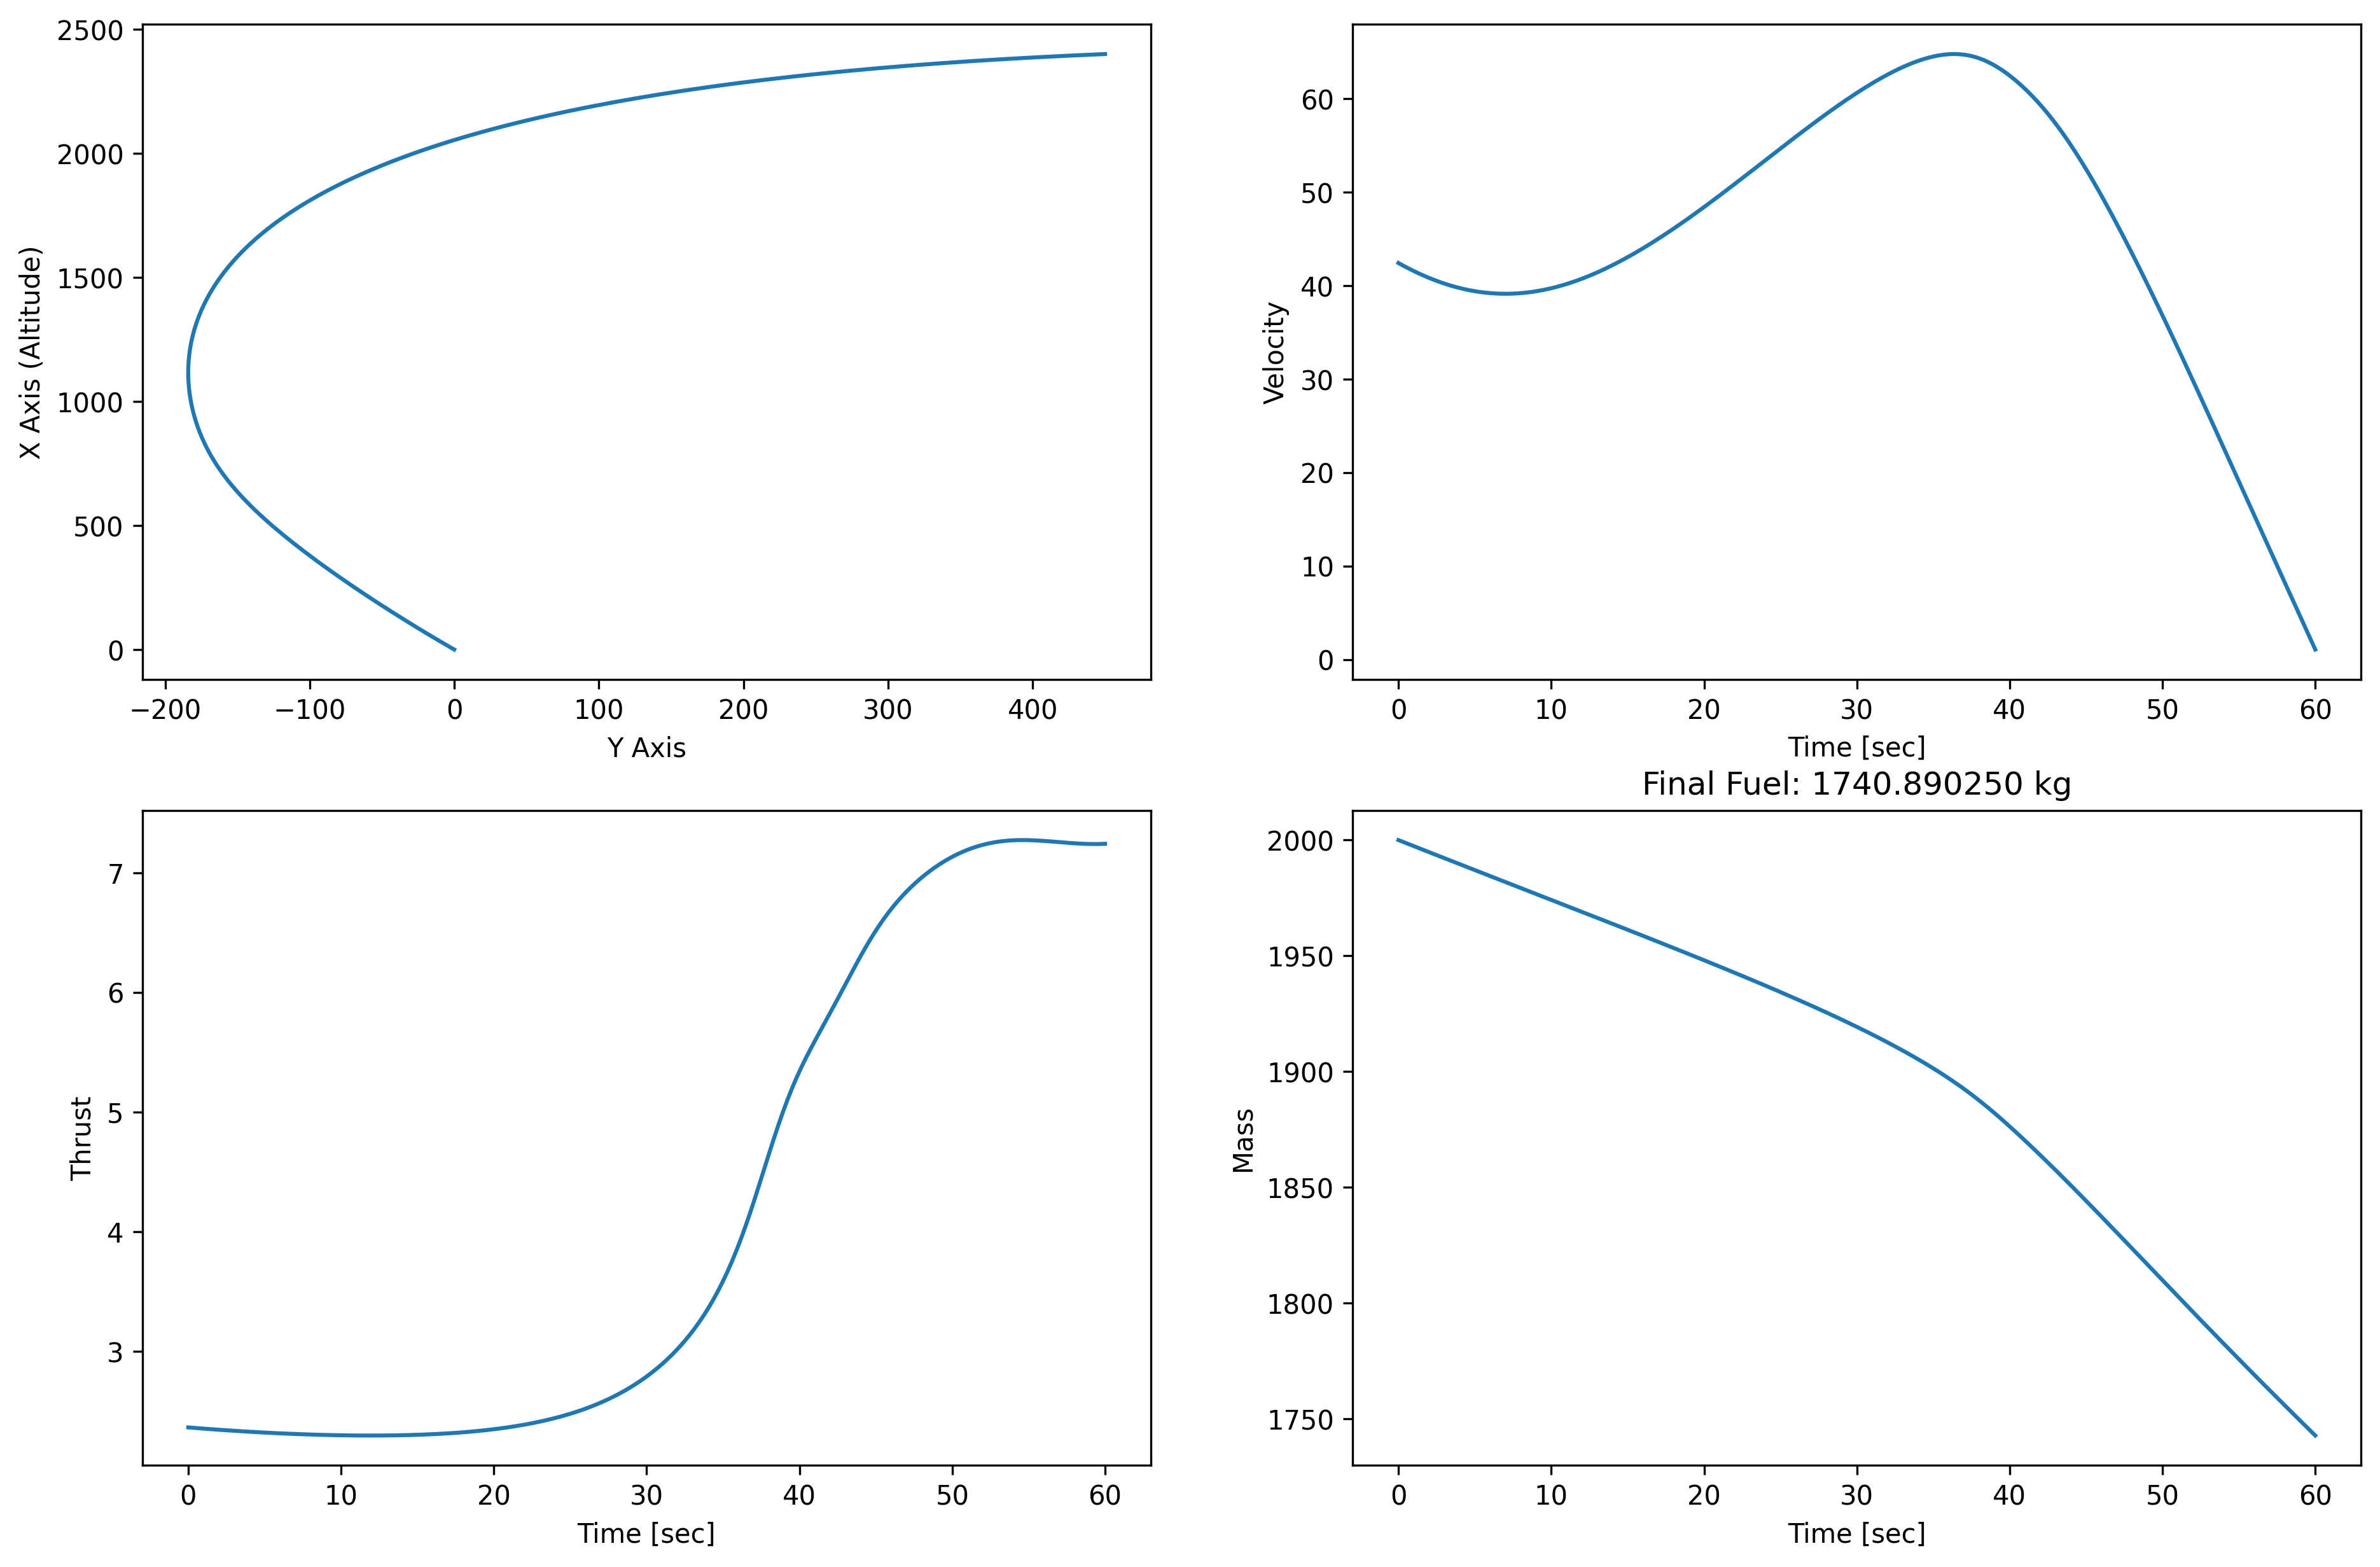

In [124]:
# Print result.
print("\nThe optimal value is", min_land_err_prob.value)
print("Solution to the X State is")

x_t_sln = x_t.value

fig = plt.figure()
plt.subplot(2,2,1)
plt.plot(x_t_sln[1,:-1], x_t_sln[0,:-1])
plt.ylabel('X Axis (Altitude)')
plt.xlabel('Y Axis')

plt.subplot(2,2,2)
plt.plot(ts, np.linalg.norm(x_t_sln[3:5+1,:-1], axis=0))
plt.ylabel('Velocity')
plt.xlabel('Time [sec]')

plt.subplot(2,2,3)
plt.plot(ts, np.linalg.norm(u_t[:,:].value, axis=0))
plt.ylabel('Thrust')
plt.xlabel('Time [sec]')

plt.subplot(2,2,4)
plt.plot(ts, (np.exp(z_t[0,:-1].value)))
plt.ylabel('Mass')
plt.xlabel('Time [sec]')
plt.title('Final Fuel: %f kg' % (np.exp(z_t[0,-1].value)))

plt.rcParams['figure.figsize'] = [20, 10]

In [125]:
# Define the Convex Relaxed Minimum Fuel Problem 

# Take the final optimal position from the Minimium Landing Error Problem
dp3 = x_t[1:2+1,-1].value # Only extract the y and z components since x is altitude

In [126]:
# Define the objective function
min_fuel_obj  = cp.Minimize(cp.sum(sigma_t))

# Cannot get variable mass to work correctly
min_fuel_const = [
                      cp.norm( E * x_t[0:2+1,-1] - q ) <= cp.norm(dp3 - q),
                      x_t[0:2+1,0] == r_0,                                       # (8)
                      x_t[3:5+1,0] == dr_0,                                     # (8)
                      cp.multiply(e1, x_t[0:2+1,-1]) == 0,                       # (9)
                      x_t[3:5+1,-1] == 0,                                        # (9) 
                      dx_t == A_w * x_t[:,0:n] + B * (np.matlib.repmat(g.T, n, 1).T + u_t ), # (17) 
                      x_t[:,1:n+1] == x_t[:,0:n] + dx_t * tstep,                # Need to update the position and velocity based on the change in states
                      # Slack variable substitute to resolve T(t)/m(t) nonconvexity
                      # Revised mass flow constraints
                      z_t[0,0] == np.log(m_0),                                   # (7)
                      z_t >= np.log(m_f),                                        # (7)
                      dz_t[0,:] == -alpha * sigma_t[0,0:n],                      # (33)
                      z_t[0,1:n+1] == z_t[0,0:n] + dz_t[0,:] * tstep,            # Need to update the mass based on the change in states

                      cp.norm(u_t, axis=0) <= sigma_t[0,:],                      # (34)
                      n_hat * u_t >= np.cos(theta) * sigma_t[0,:],               # (34) # Should substitute n_hat with an actual value

                      # Revised control constraints
                      rho_1 * np.exp(-z_0[0]) * ((1 - (z_t[0,0:n] - z_0)) + cp.power((z_t[0,0:n] - z_0),2) / 2) <= sigma_t[0,:],
                      sigma_t[0,:] <= rho_2 * np.exp(-z_0[0]) * (1 - (z_t[0,0:n] - z_0)),
                      ]       # (19)

min_fuel_prob = cp.Problem(min_fuel_obj, min_fuel_const)

In [127]:
min_fuel_prob.solve()  # Returns the optimal value.

814.0948184810987


The optimal value is 814.0948184810987
Solution to the X State is


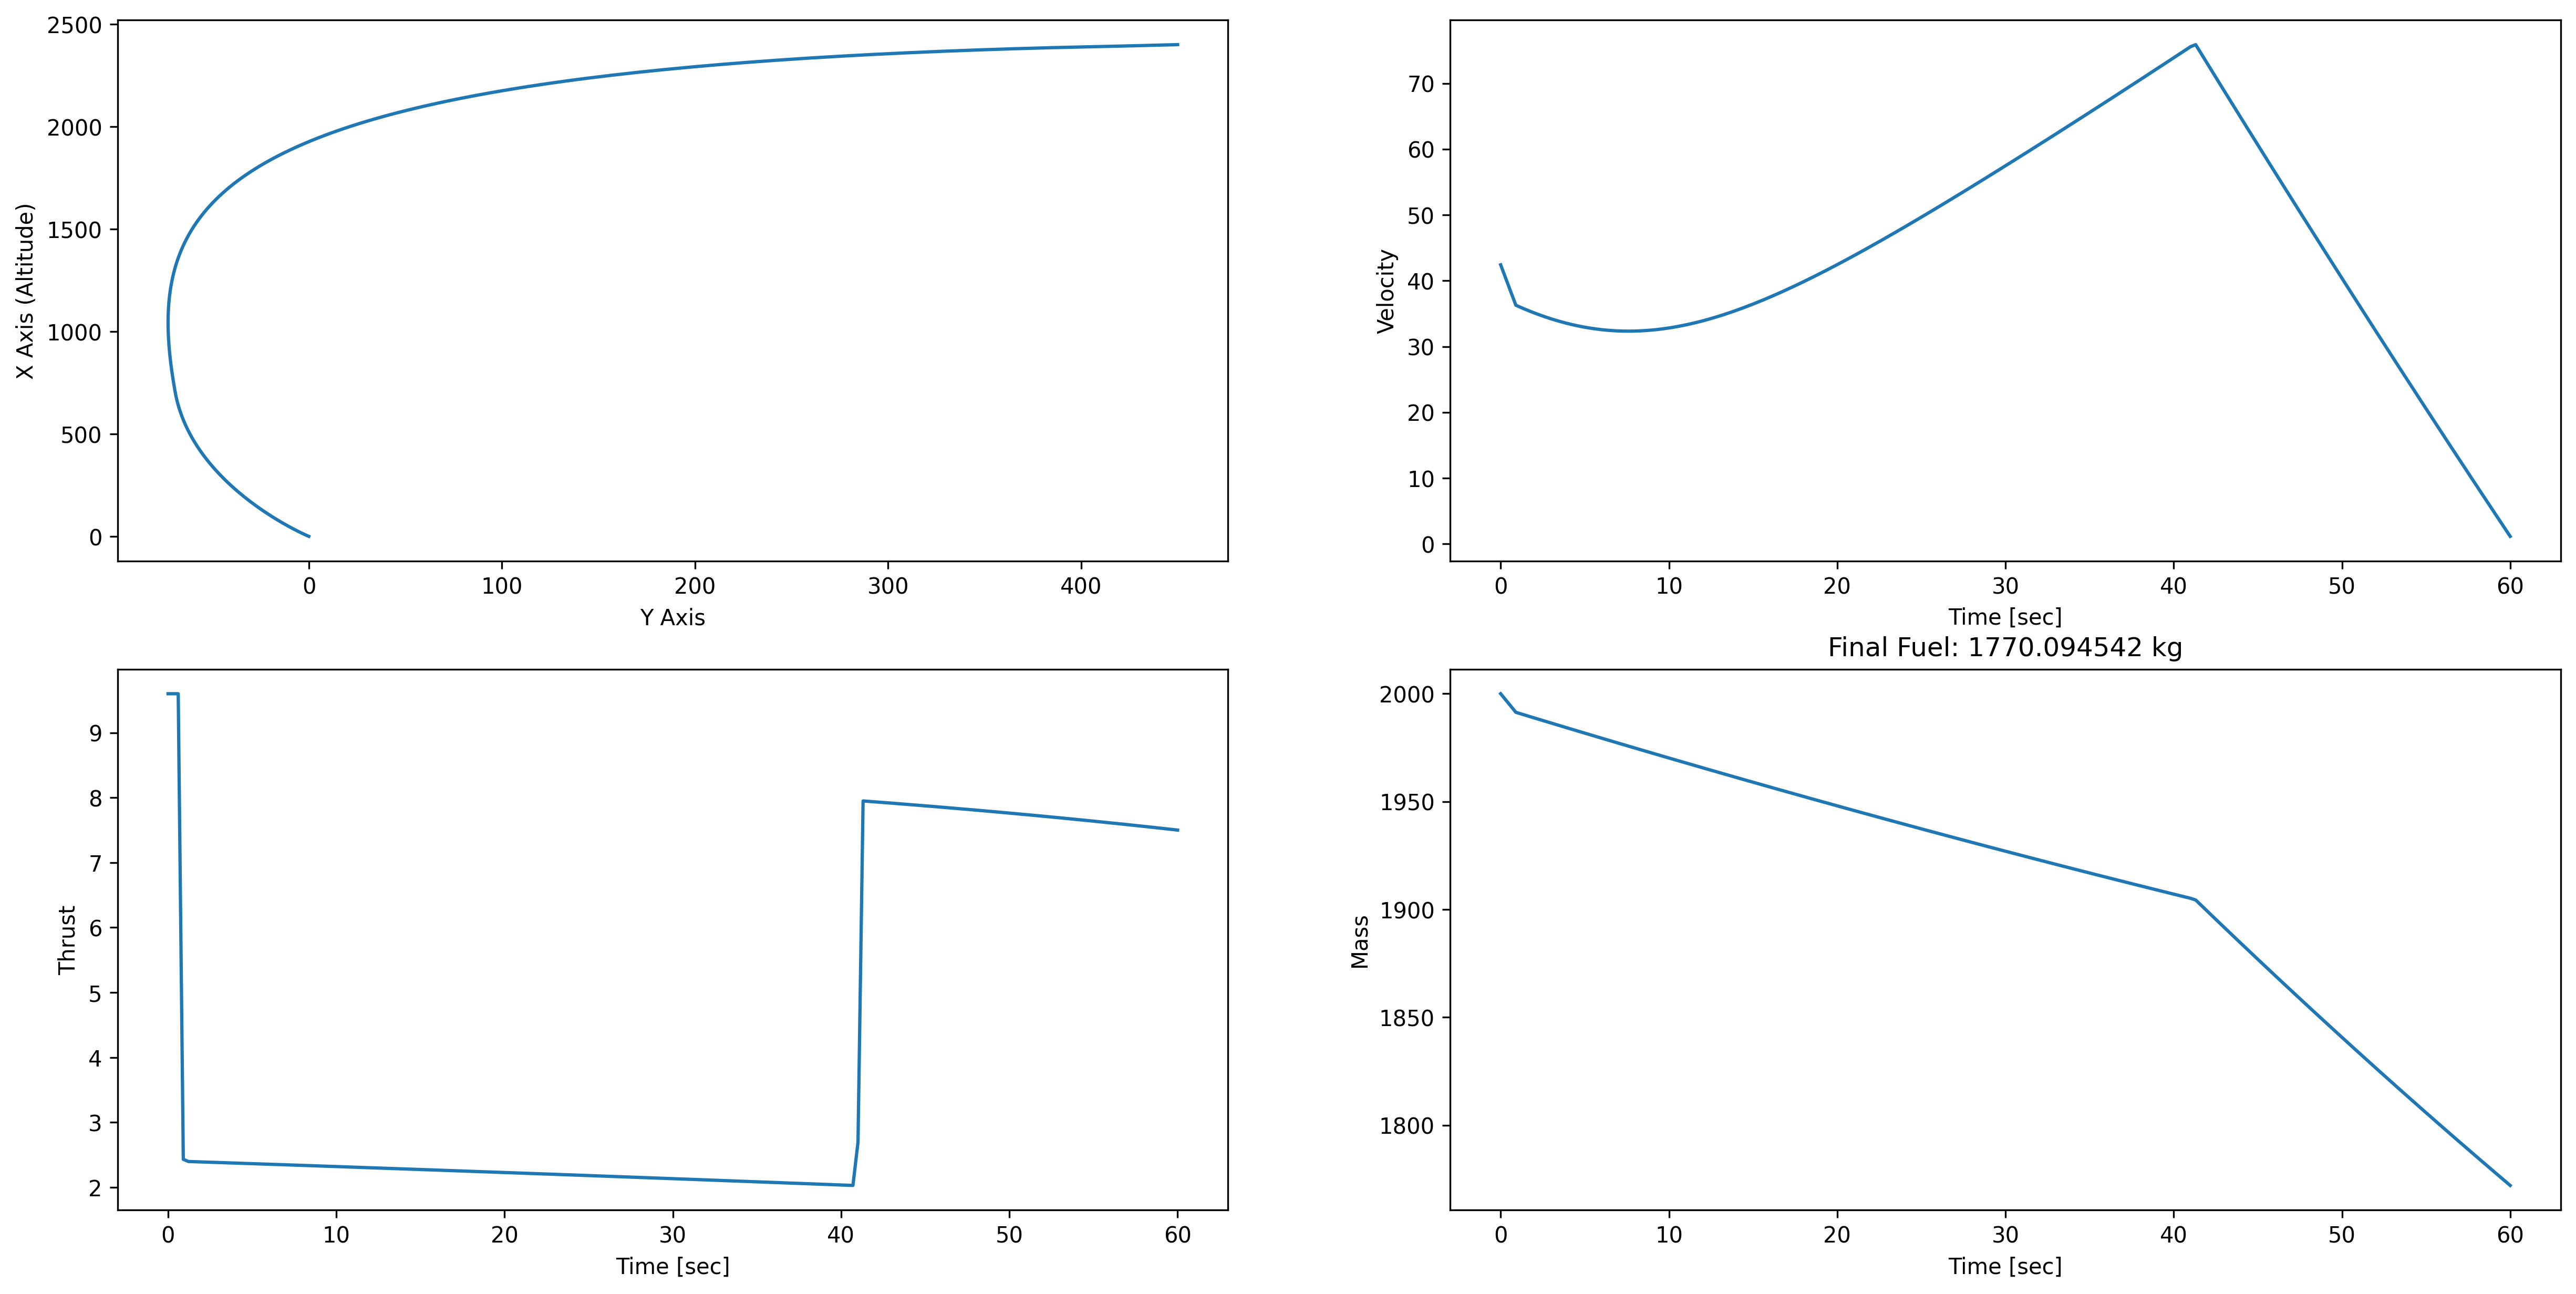

In [128]:
# Print result.
print("\nThe optimal value is", min_fuel_prob.value)
print("Solution to the X State is")

x_t_sln = x_t.value

fig = plt.figure()
plt.subplot(2,2,1)
plt.plot(x_t_sln[1,:-1], x_t_sln[0,:-1])
plt.ylabel('X Axis (Altitude)')
plt.xlabel('Y Axis')

plt.subplot(2,2,2)
plt.plot(ts, np.linalg.norm(x_t_sln[3:5+1,:-1], axis=0))
plt.ylabel('Velocity')
plt.xlabel('Time [sec]')

plt.subplot(2,2,3)
plt.plot(ts, np.linalg.norm(u_t[:,:].value, axis=0))
plt.ylabel('Thrust')
plt.xlabel('Time [sec]')

plt.subplot(2,2,4)
plt.plot(ts, (np.exp(z_t[0,:-1].value)))
plt.ylabel('Mass')
plt.xlabel('Time [sec]')
plt.title('Final Fuel: %f kg' % (np.exp(z_t[0,-1].value)))

plt.rcParams['figure.figsize'] = [15, 10]